# EMRI Waveforms in Fourier Domain
Here we present the usage of the EMRI Waveforms in Fourier Domain. Currently we implemented the Fourier Domain Waveform only for the Schawrzchild case.

In [1]:
import sys, time, h5py
import numpy as np
import matplotlib.pyplot as plt
# import or install these packages for the data anlysis of the resultss
sys.path.append("../LISAanalysistools/")
sys.path.append("../Eryn/")

import corner
from lisatools.sampling.likelihood import Likelihood
from lisatools.diagnostic import *
from lisatools.sensitivity import get_sensitivity

from few.waveform import GenerateEMRIWaveform
from few.utils.utility import get_mu_at_t
from few.utils.constants import *
from few.utils.utility import omp_set_num_threads
omp_set_num_threads(8)

try:
    import cupy as xp
    # set GPU device
    xp.cuda.runtime.setDevice(3)
    use_gpu = True

except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    use_gpu = False

import warnings
warnings.filterwarnings("ignore")


few_gen = GenerateEMRIWaveform(
    "FastSchwarzschildEccentricFlux", 
    sum_kwargs=dict(pad_output=True, output_type="fd",odd_len=True),
    use_gpu=use_gpu,
    return_list=True
)

td_gen = GenerateEMRIWaveform(
    "FastSchwarzschildEccentricFlux", 
    sum_kwargs=dict(pad_output=True,odd_len=True),
    use_gpu=use_gpu,
    return_list=True
)

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]



In [2]:
!gpustat

saraswati.aei.mpg.de      Sun May 21 13:36:32 2023  515.43.04
[0] NVIDIA A100-SXM4-40GB | 24'C,   0 % |   572 / 40960 MB |
[1] NVIDIA A100-SXM4-40GB | 24'C,   0 % | 29133 / 40960 MB | nihargupte(28473M)
[2] NVIDIA A100-SXM4-40GB | 23'C,   0 % | 29087 / 40960 MB | nihargupte(28423M)
[3] NVIDIA A100-SXM4-40GB | 25'C,   0 % |  1047 / 40960 MB | lsperi(473M)
[4] NVIDIA A100-SXM4-40GB | 23'C,   0 % |   572 / 40960 MB |
[5] NVIDIA A100-SXM4-40GB | 22'C,   0 % |   572 / 40960 MB |
[6] NVIDIA A100-SXM4-40GB | 23'C,   0 % |   574 / 40960 MB |
[7] NVIDIA A100-SXM4-40GB | 25'C,  34 % |  5107 / 40960 MB | lsperi(4535M)


In [3]:
# define the injection parameters
M = 1e6 # central object mass
a = 0.1  # will be ignored in Schwarzschild waveform
mu = 20.0 # secondary object mass
p0 = 12.0 # initial semi-latus rectum
e0 = 0.35 # eccentricity
x0 = 1.0  # will be ignored in Schwarzschild waveform
qK = np.pi/5  # polar spin angle
phiK = np.pi/3  # azimuthal viewing angle
qS = np.pi/4  # polar sky angle
phiS = np.pi/6  # azimuthal viewing angle
dist = 3.0  # distance
# initial phases
Phi_phi0 = 1.0
Phi_theta0 = 2.0
Phi_r0 = 3.0

Tobs = 2.0 # observation time, if the inspiral is shorter, the it will be zero padded 
dt = 10.0 # time interval
eps = 1e-5 # mode content percentage
mode_selection = [(5,-2,-7)]

waveform_kwargs = {
    "T": Tobs,
    "dt": dt,
# you can uncomment the following ling if you want to show a mode
#     "mode_selection" : mode_selection,
    "eps": eps
}

emri_injection_params = [
                            M,  
                            mu,
                            a, 
                            p0, 
                            e0, 
                            x0,
                            dist, 
                            qS,
                            phiS,
                            qK, 
                            phiK, 
                            Phi_phi0, 
                            Phi_theta0, 
                            Phi_r0
                        ]

## Comparison against the Time Domain Waveforms

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


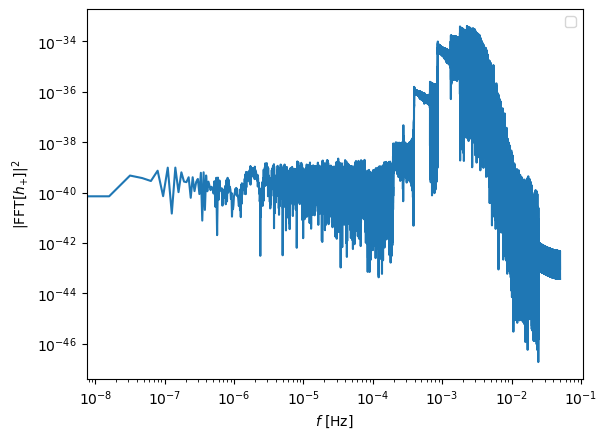

In [4]:
# create TD signal
data_channels_td = td_gen(*emri_injection_params, **waveform_kwargs)

# take the FFT of the plus polarization and shift it
fft_TD = xp.fft.fftshift(xp.fft.fft(data_channels_td[0])) * dt
freq = xp.fft.fftshift(xp.fft.fftfreq(len(data_channels_td[0]) , dt))

# define the positive frequencies
positive_frequency_mask = (freq>=0.0)
    
plt.figure()
if use_gpu:
    plt.loglog(freq[positive_frequency_mask].get(), np.abs(fft_TD[positive_frequency_mask].get())**2)
else:
    plt.loglog(freq[positive_frequency_mask], np.abs(fft_TD[positive_frequency_mask])**2)
plt.ylabel(r'$| {\rm FFT} [h_{+}]|^2$')
plt.xlabel(r'$f$ [Hz]')
plt.legend()
plt.show()

In [5]:
# check that the frequency array is an odd number
len(freq)

6311631

In [6]:
# you can specify the frequencies or obtain them directly from the waveform
fd_kwargs = waveform_kwargs.copy()
fd_kwargs['f_arr'] = freq
fd_kwargs['mask_positive']=True

hf = few_gen(*emri_injection_params,**fd_kwargs)
# to get the frequencies:
freq_fd = few_gen.waveform_generator.create_waveform.frequency

# mask where the FD waveform is non zero
non_zero_mask = (xp.abs(hf[0])>1e-50)

# mismatch
fd_inner_product_kwargs = dict( PSD="cornish_lisa_psd", use_gpu=use_gpu, f_arr=freq[positive_frequency_mask])
Mism = np.abs(1-inner_product(fft_TD[positive_frequency_mask], hf[0], normalize=True, **fd_inner_product_kwargs))
print("mismatch", Mism)
Mism = np.abs(1-inner_product(fft_TD[positive_frequency_mask][non_zero_mask], hf[0][non_zero_mask], normalize=True, 
                **dict( PSD="cornish_lisa_psd", use_gpu=use_gpu, f_arr=freq[positive_frequency_mask][non_zero_mask])))
print("mismatch", Mism)



mismatch 0.000908838822552771
mismatch 0.0009087640849998468


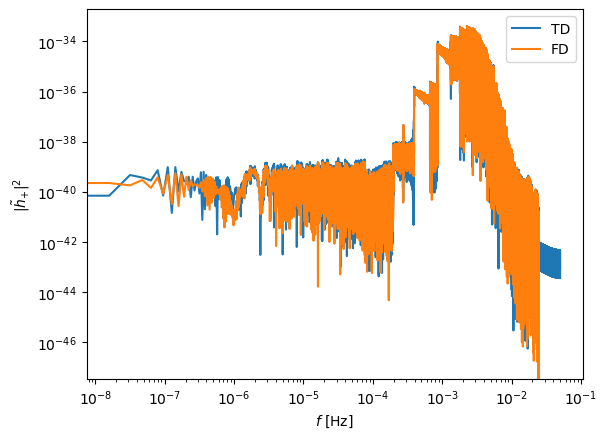

In [23]:
# FD plot
plt.figure()
if use_gpu:
    plt.loglog(freq[positive_frequency_mask].get(), np.abs(fft_TD[positive_frequency_mask].get())**2,label='TD')
    plt.loglog(freq[positive_frequency_mask].get(), np.abs(hf[0].get())**2,label='FD')
else:
    plt.loglog(freq[positive_frequency_mask], np.abs(fft_TD[positive_frequency_mask])**2,label='TD')
    plt.loglog(freq[positive_frequency_mask], np.abs(hf[0])**2,label='FD')
plt.ylabel(r'$| \tilde{h}_{+}|^2$')
plt.xlabel(r'$f$ [Hz]')
plt.legend()
plt.show()

(10000000.0, 10050000.0)

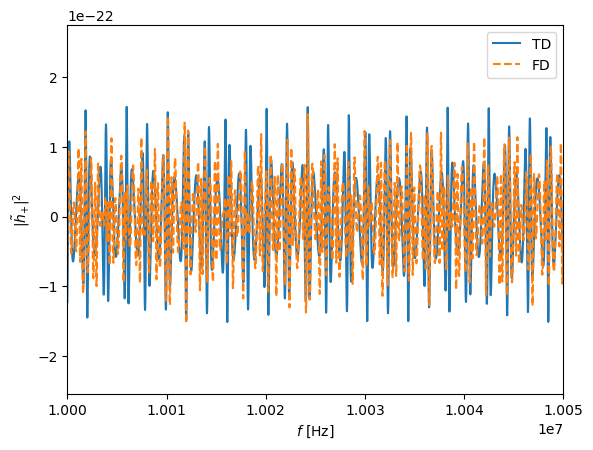

In [8]:
# TD plot
time_array = np.arange(0,len(data_channels_td[0]))*dt
ifft_fd = xp.fft.ifft(xp.append(hf[0],xp.flip(hf[0][1:] ))/dt)

plt.figure()
if use_gpu:
    plt.plot(time_array, data_channels_td[0].get(),label='TD')
    plt.plot(time_array, ifft_fd.get(),'--' ,label='FD')
else:
    plt.plot(time_array, data_channels_td[0],label='TD')
    plt.plot(time_array, ifft_fd,'--' ,label='FD')

plt.ylabel(r'$| \tilde{h}_{+}|^2$')
plt.xlabel(r'$f$ [Hz]')
plt.legend()
t0 = 1e7
space_t = 5e4
plt.xlim([t0,t0+space_t])

## Frequency downsampling

In [65]:

# list the indeces 
lst_ind = list(range(len(freq)))
upp = 50000
# make sure there is the zero frequency when you jump
check_vec = xp.asarray([1==xp.sum(freq[lst_ind[0::ii]]==0.0) for ii in range(2,upp)])
# find the one that has the zero frequency
ii = int(xp.arange(2,upp)[check_vec][-1])
print('--------------------------')
print('skip every ',ii, 'th element')
print('number of frequencies', len(freq[lst_ind[0::ii]]))
print('percentage of frequencies', len(freq[lst_ind[0::ii]])/len(freq))
# add f_arr to the kwarguments
if use_gpu:
    f_arr = freq[lst_ind[0::ii]][freq[lst_ind[0::ii]]>=0.0]
else:
    f_arr = freq[lst_ind[0::ii]][freq[lst_ind[0::ii]]>=0.0].get()

fd_kwargs = waveform_kwargs.copy()
fd_kwargs['f_arr'] = freq[lst_ind[0::ii]]
fd_kwargs['mask_positive'] = True

positive_mask = (f_arr>=0.0)
fd_kwargs

--------------------------
skip every  48551 th element
number of frequencies 131
percentage of frequencies 2.0755332496465653e-05


{'T': 2.0,
 'dt': 10.0,
 'eps': 1e-05,
 'f_arr': array([-0.04999999, -0.04923076, -0.04846153, -0.0476923 , -0.04692307,
        -0.04615384, -0.04538461, -0.04461538, -0.04384615, -0.04307692,
        -0.04230769, -0.04153845, -0.04076922, -0.03999999, -0.03923076,
        -0.03846153, -0.0376923 , -0.03692307, -0.03615384, -0.03538461,
        -0.03461538, -0.03384615, -0.03307692, -0.03230769, -0.03153846,
        -0.03076923, -0.03      , -0.02923076, -0.02846153, -0.0276923 ,
        -0.02692307, -0.02615384, -0.02538461, -0.02461538, -0.02384615,
        -0.02307692, -0.02230769, -0.02153846, -0.02076923, -0.02      ,
        -0.01923077, -0.01846154, -0.0176923 , -0.01692307, -0.01615384,
        -0.01538461, -0.01461538, -0.01384615, -0.01307692, -0.01230769,
        -0.01153846, -0.01076923, -0.01      , -0.00923077, -0.00846154,
        -0.00769231, -0.00692308, -0.00615385, -0.00538461, -0.00461538,
        -0.00384615, -0.00307692, -0.00230769, -0.00153846, -0.00076923,
   

In [66]:
# generate wave
tic = time.time()
tmp_hf = few_gen(*emri_injection_params, **fd_kwargs)
toc = time.time()
print('timing ', toc - tic)

fd_inner_product_kwargs = dict( PSD="cornish_lisa_psd", use_gpu=use_gpu, f_arr=f_arr)

Mism = np.abs(1-inner_product(tmp_hf[0], hf[0][0::ii][positive_mask], normalize=True, **fd_inner_product_kwargs))
print('mimsatch = ',Mism)

timing  0.03686022758483887
mimsatch =  2.220446049250313e-16


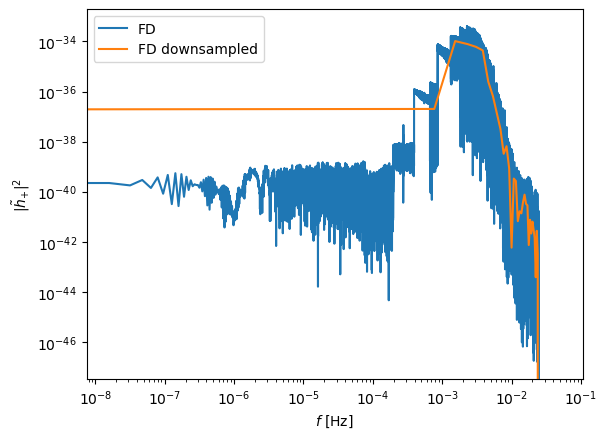

In [67]:
# FD plot
plt.figure()
# if use_gpu:
plt.loglog(freq[positive_frequency_mask].get(), np.abs(hf[0].get())**2,label='FD')
plt.loglog(f_arr[positive_mask].get(), np.abs(tmp_hf[0][positive_mask].get())**2,label='FD downsampled')
# else:
#     plt.loglog(freq[positive_frequency_mask], np.abs(fft_TD[positive_frequency_mask])**2,label='TD')
#     plt.loglog(freq[positive_frequency_mask], np.abs(hf[0])**2,label='FD')
plt.ylabel(r'$| \tilde{h}_{+}|^2$')
plt.xlabel(r'$f$ [Hz]')
plt.legend()
plt.show()

## Mass invariance

In [68]:
list_h = []
list_f = []
T = 4.0
dt = 10.0
Mvec = 10**np.linspace(5.0,6.5,num=3)

for M in Mvec:

    # fix mass ratio
    mu = 5e-5*M

    # rescale time
    Tnew = T*(M/1e6)
    
    # generate wave
    list_h.append(
        few_gen(M,mu,a,p0,e0,x0,dist,qS,phiS,qK,phiK,Phi_phi0,Phi_theta0,Phi_r0,
                T=10.0,dt=dt,mode_selection=[(2,2,0)],mask_positive=True)
    )

    # adimensionless frequency
    list_f.append(few_gen.waveform_generator.create_waveform.frequency * M * MTSUN_SI )
    

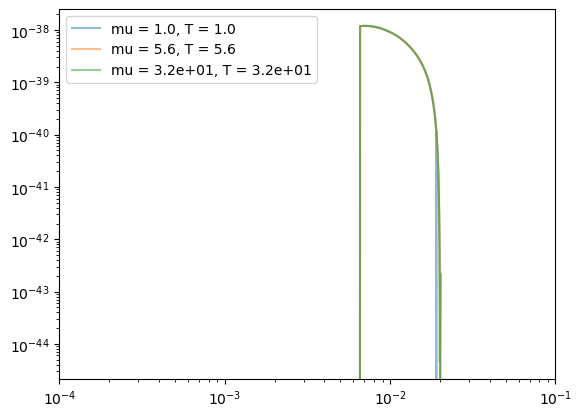

In [69]:
plt.figure()

for ii in range(len(Mvec)):
    Tnew = 10.0 * Mvec[ii] / 1e6
    tmp_mu = 1e-5 * Mvec[ii]
    
    ff = list_f[ii].get()
    ff = ff[ff>=0.0]
    h2 = np.abs(list_h[ii][0].get() / (tmp_mu * Tnew) )**2 
    plt.loglog(ff, h2,'--', label = f'mu = {tmp_mu:.2}, T = {Tnew:.2}',alpha=0.5)

plt.xlim([1e-4,1e-1])
plt.legend()
plt.show()

## Speed analysis

In [89]:
import glob
# files = sorted(glob.glob('*T4.05*_.h5'))
# files = sorted(glob.glob('*seed2601996_dt8*_.h5'))
# files = sorted(glob.glob('*T4.05_seed2601996_dt5.0*_.h5'))
files = sorted(glob.glob('*fixedInsp1*.h5'))

In [90]:
files

['emri_T2.0_seed2601996_dt1.0_eps0.01_fixedInsp1.h5',
 'emri_T2.0_seed2601996_dt5.0_eps0.01_fixedInsp1.h5']

In [91]:
speed_up_factor = []
injection_pars = []
dt_T_eps = []
mismatch = []

for ff in files:
    # ff = files[0]
    print(ff)
    dset = h5py.File(ff,'r')
    speed_up_factor.append(dset['timing_td'][...]/dset['timing_fd'][...])
    injection_pars.append(dset['list_injections'][...])
    mismatch.append(np.log10(dset['mismatch'][...]))
    dt_T_eps.append([dset['dt'][...], dset['T'][...], dset['eps'][...] ])
    dset.close()

emri_T2.0_seed2601996_dt1.0_eps0.01_fixedInsp1.h5
emri_T2.0_seed2601996_dt5.0_eps0.01_fixedInsp1.h5


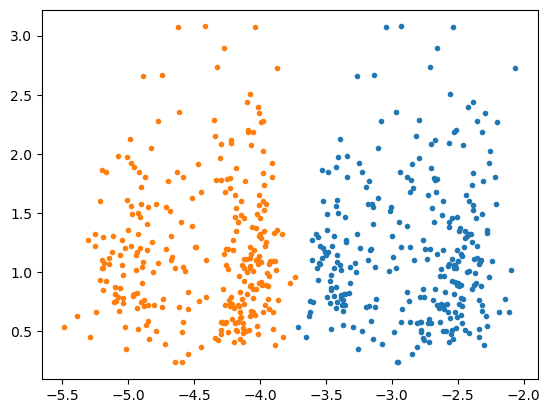

In [93]:
plt.plot(mismatch[0],speed_up_factor[0],'.')

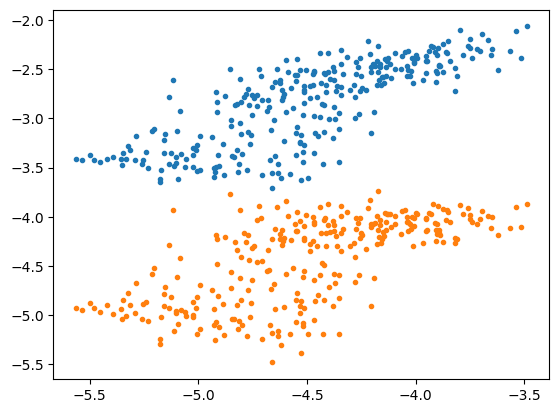

In [95]:
ii = 0
plt.plot(np.log10(injection_pars[ii][:,1]/injection_pars[ii][:,0]),mismatch[ii],'.')

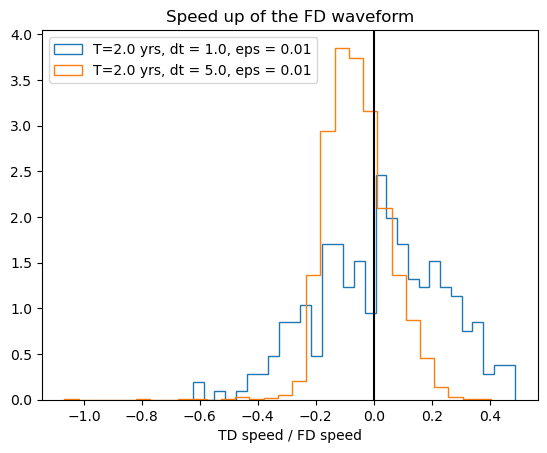

In [96]:
plt.figure()
plt.title(f'Speed up of the FD waveform')
[plt.hist(np.log10(speed),histtype='step', label=f'T={el[1]} yrs, dt = {el[0]}, eps = {el[2]}',density=True,bins=30) for speed,el in zip(speed_up_factor,dt_T_eps)]
plt.xlabel('TD speed / FD speed')
plt.legend()

plt.axvline(0.0,color='k')
plt.show()

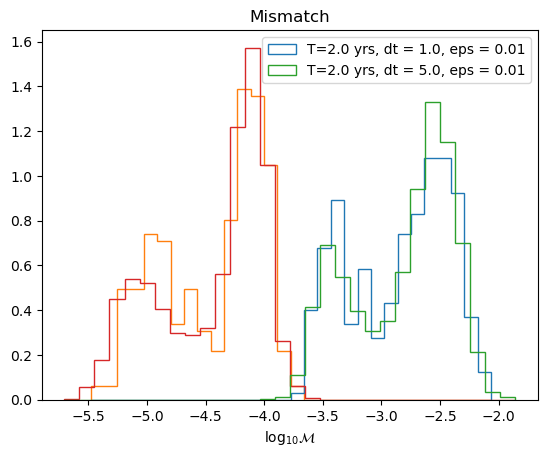

In [97]:
plt.figure()
plt.title(f'Mismatch')
[plt.hist(speed,histtype='step', label=f'T={el[1]} yrs, dt = {el[0]}, eps = {el[2]}',density=True,bins=30) for speed,el in zip(mismatch,dt_T_eps)]
plt.xlabel('$\log_{10}\mathcal{M}$')
plt.legend()
plt.show()

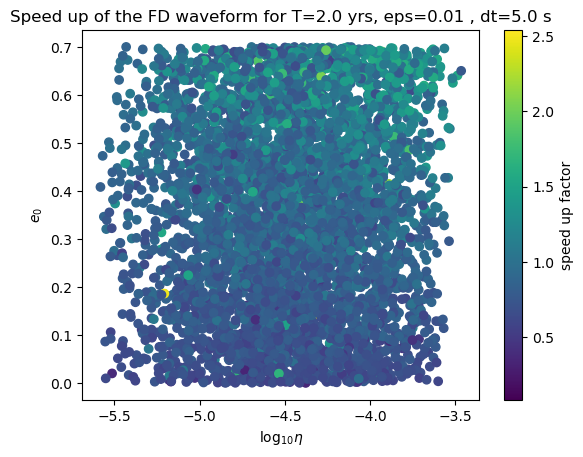

In [98]:
ii = 1
# Generate random data
x = np.log10(injection_pars[ii][:,1]/injection_pars[ii][:,0])
y = injection_pars[ii][:,4]
z = speed_up_factor[ii]

# Define color scheme
cmap = plt.get_cmap('viridis')
colors = cmap(z)

# Plot scatter plot with colormap and color bar
fig, ax = plt.subplots()
plt.title(f'Speed up of the FD waveform for T={dt_T_eps[ii][1]} yrs, eps={dt_T_eps[ii][2]} , dt={dt_T_eps[ii][0]} s')

plt.scatter(x, y, c=z, cmap=cmap)
plt.colorbar(label='speed up factor')

# Set axis labels and title
ax.set_xlabel('$\log_{10}\eta$')
ax.set_ylabel('$e_0$')
# ax.set_title('Speed up as a function of the parameter spac')

# Show the plot
plt.show()

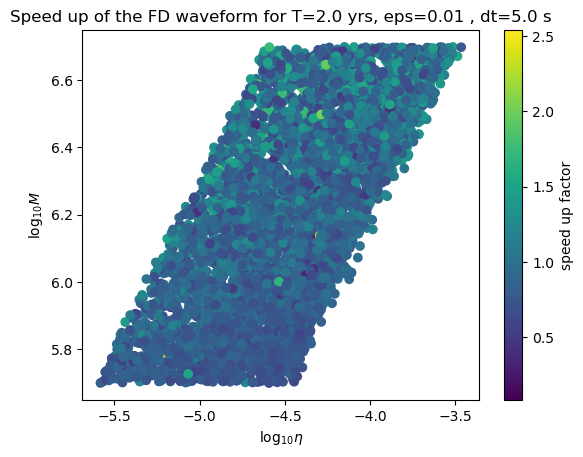

In [99]:
ii = 1
# Generate random data
x = np.log10(injection_pars[ii][:,1]/injection_pars[ii][:,0])
y = np.log10(injection_pars[ii][:,0])
z = speed_up_factor[ii]

# Define color scheme
cmap = plt.get_cmap('viridis')
colors = cmap(z)

# Plot scatter plot with colormap and color bar
fig, ax = plt.subplots()
plt.title(f'Speed up of the FD waveform for T={dt_T_eps[ii][1]} yrs, eps={dt_T_eps[ii][2]} , dt={dt_T_eps[ii][0]} s')
plt.scatter(x, y, c=z, cmap=cmap)
plt.colorbar(label='speed up factor')

# Set axis labels and title
ax.set_xlabel('$\log_{10} \eta$')
ax.set_ylabel('$\log_{10} M$')
# ax.set_title('Speed up as a function of the parameter spac')

# Show the plot
plt.show()

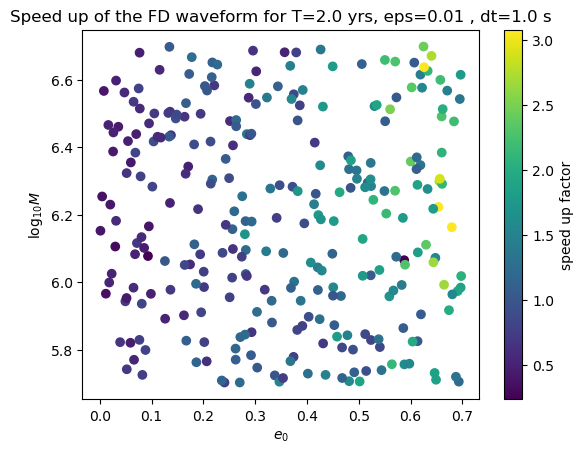

In [100]:
ii = 0
# Generate random data
x = injection_pars[ii][:,4]
y = np.log10(injection_pars[ii][:,0])
z = speed_up_factor[ii]

# Define color scheme
cmap = plt.get_cmap('viridis')
colors = cmap(z)

# Plot scatter plot with colormap and color bar
fig, ax = plt.subplots()
plt.title(f'Speed up of the FD waveform for T={dt_T_eps[ii][1]} yrs, eps={dt_T_eps[ii][2]} , dt={dt_T_eps[ii][0]} s')
plt.scatter(x, y, c=z, cmap=cmap)
plt.colorbar(label='speed up factor')

# Set axis labels and title
ax.set_xlabel('$e_0$')
ax.set_ylabel('$\log_{10} M$')
# ax.set_title('Speed up as a function of the parameter spac')

# Show the plot
plt.show()

## Posterior comparison

In [30]:
from eryn.backends import HDFBackend
import h5py, glob

In [31]:
def get_autocorr_plot(to_check):
    n_dim  = to_check.shape[-1]
    plt.figure()
    for var in range(n_dim):
        y = to_check[:,:,var].T
        # Compute the estimators for a few different chain lengths
        N = np.exp(np.linspace(np.log(100), np.log(y.shape[1]), 10)).astype(int)
        gw2010 = np.empty(len(N))
        new = np.empty(len(N))
        for i, n in enumerate(N):
            gw2010[i] = autocorr_gw2010(y[:, :n])
            new[i] = autocorr_new(y[:, :n])

        # Plot the comparisons
        # plt.loglog(N, gw2010, "o-", label="G&W 2010")
        plt.loglog(N, new, "o-", label=f"new var{var}")

    plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
    # plt.axhline(true_tau, color="k", label="truth", zorder=-100)
    plt.xlabel("number of samples, $N$")
    plt.ylabel(r"$\tau$ estimates")
    plt.legend(fontsize=14);
    plt.show()



In [74]:
datasets = glob.glob('*downsample*.h5')
datasets
samp.shape

(1751, 32, 1, 11)

{'StretchMove_0': {'acceptance_fraction': array([[0.30802 , 0.331425, 0.342835, 0.292585, 0.34098 , 0.29542 ,
        0.338635, 0.334185, 0.336455, 0.33921 , 0.32496 , 0.312225,
        0.32632 , 0.31305 , 0.3404  , 0.34223 , 0.34344 , 0.331375,
        0.340925, 0.333765, 0.331505, 0.344245, 0.3365  , 0.33985 ,
        0.34366 , 0.33742 , 0.34982 , 0.325095, 0.340505, 0.329105,
        0.327995, 0.31959 ],
       [0.446175, 0.44193 , 0.44279 , 0.44816 , 0.44743 , 0.441805,
        0.4437  , 0.446005, 0.4461  , 0.44372 , 0.44278 , 0.444795,
        0.445685, 0.442455, 0.444725, 0.44481 , 0.441565, 0.446615,
        0.444205, 0.44666 , 0.45001 , 0.447745, 0.44446 , 0.448905,
        0.44582 , 0.445635, 0.447705, 0.445025, 0.448375, 0.44654 ,
        0.447425, 0.445505]])}}


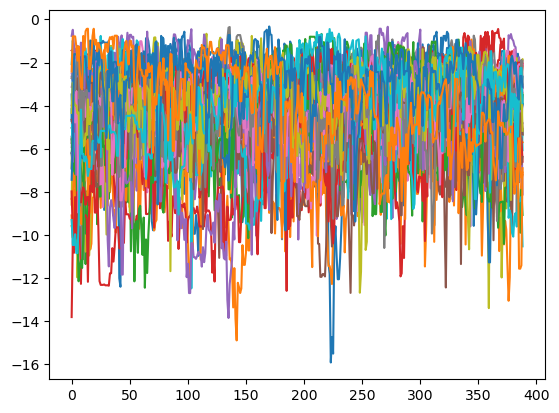

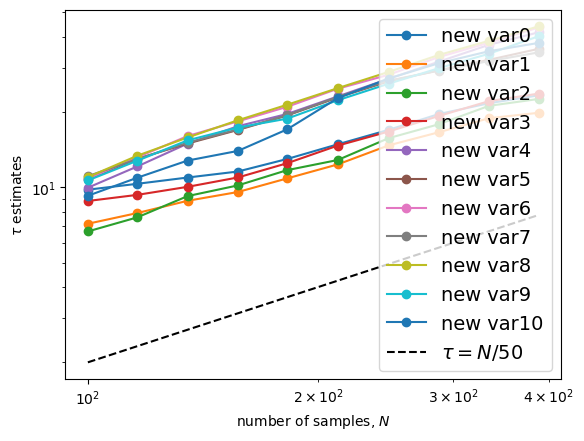

{'StretchMove_0': {'acceptance_fraction': array([[0.324615, 0.325805, 0.332765, 0.324545, 0.32646 , 0.338005,
        0.3212  , 0.34538 , 0.335445, 0.344645, 0.337215, 0.316905,
        0.33759 , 0.341095, 0.315905, 0.333385, 0.326755, 0.332295,
        0.326775, 0.308115, 0.322385, 0.330365, 0.33477 , 0.32639 ,
        0.323335, 0.338125, 0.32283 , 0.326085, 0.33209 , 0.32374 ,
        0.336335, 0.3288  ],
       [0.443925, 0.447545, 0.44464 , 0.446675, 0.4471  , 0.443725,
        0.44435 , 0.443505, 0.44714 , 0.44343 , 0.44374 , 0.44239 ,
        0.44631 , 0.445265, 0.44598 , 0.44459 , 0.4481  , 0.44139 ,
        0.444155, 0.447015, 0.44688 , 0.443505, 0.44556 , 0.44195 ,
        0.447185, 0.445845, 0.44553 , 0.44766 , 0.44556 , 0.444635,
        0.44515 , 0.4478  ]])}}


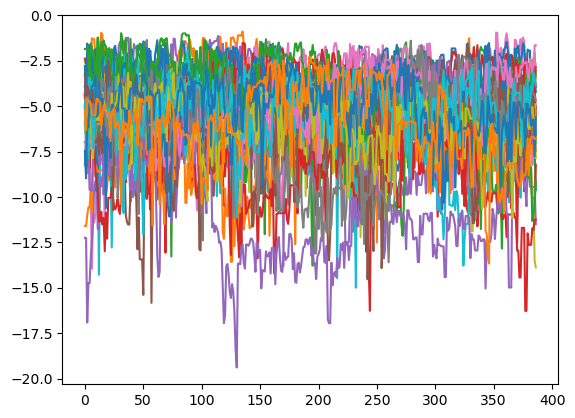

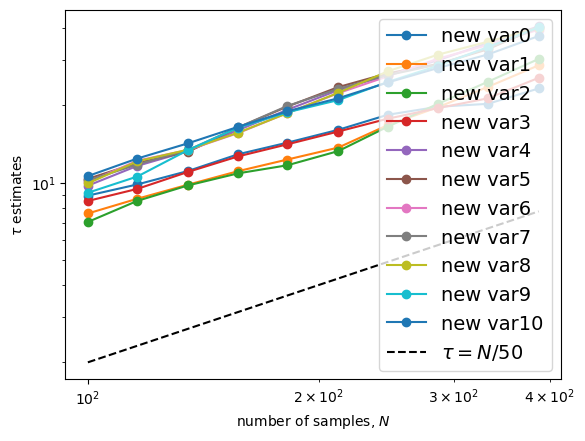

{'StretchMove_0': {'acceptance_fraction': array([[0.22413793, 0.24137931, 0.39655172, 0.24137931, 0.17241379,
        0.4137931 , 0.37931034, 0.25862069, 0.43103448, 0.32758621,
        0.24137931, 0.51724138, 0.4137931 , 0.15517241, 0.46551724,
        0.27586207, 0.36206897, 0.24137931, 0.39655172, 0.12068966,
        0.13793103, 0.32758621, 0.25862069, 0.32758621, 0.34482759,
        0.36206897, 0.43103448, 0.29310345, 0.37931034, 0.48275862,
        0.18965517, 0.32758621],
       [0.37931034, 0.34482759, 0.37931034, 0.36206897, 0.25862069,
        0.13793103, 0.5862069 , 0.46551724, 0.32758621, 0.32758621,
        0.46551724, 0.32758621, 0.34482759, 0.31034483, 0.51724138,
        0.53448276, 0.39655172, 0.4137931 , 0.27586207, 0.37931034,
        0.5       , 0.24137931, 0.36206897, 0.44827586, 0.5       ,
        0.43103448, 0.5862069 , 0.5862069 , 0.62068966, 0.36206897,
        0.27586207, 0.43103448]])}}


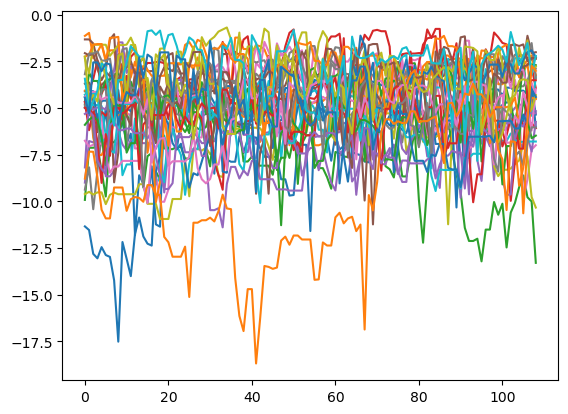

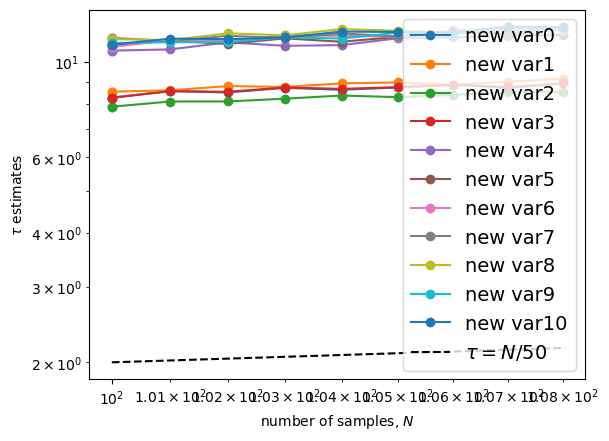

{'StretchMove_0': {'acceptance_fraction': array([[0.323145, 0.326275, 0.323995, 0.34138 , 0.343075, 0.32973 ,
        0.333755, 0.339125, 0.347815, 0.341055, 0.343875, 0.34567 ,
        0.334815, 0.328475, 0.341515, 0.323035, 0.32211 , 0.33346 ,
        0.33307 , 0.33308 , 0.3264  , 0.33037 , 0.34403 , 0.344965,
        0.32874 , 0.32471 , 0.321285, 0.321605, 0.338645, 0.325255,
        0.337715, 0.32121 ],
       [0.44422 , 0.444905, 0.44542 , 0.44293 , 0.444685, 0.448755,
        0.44539 , 0.446975, 0.448435, 0.444365, 0.444225, 0.445695,
        0.44248 , 0.44778 , 0.442745, 0.443745, 0.44396 , 0.443365,
        0.444035, 0.4486  , 0.444115, 0.44786 , 0.4478  , 0.444745,
        0.44492 , 0.44571 , 0.44529 , 0.446375, 0.443935, 0.441815,
        0.446825, 0.445135]])}}


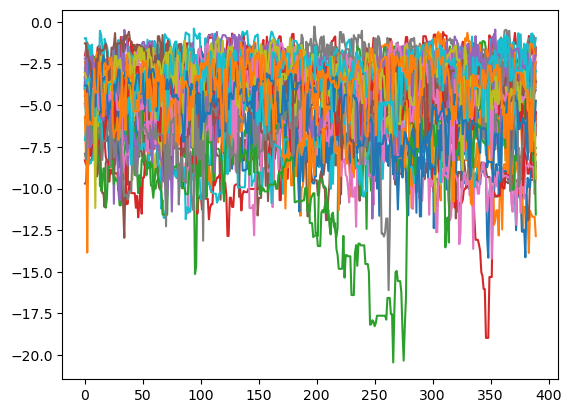

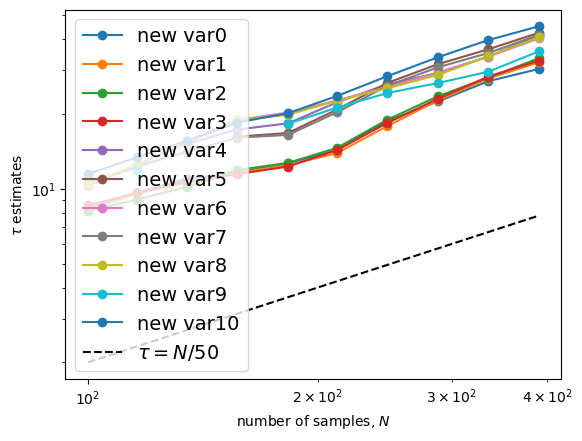

In [132]:
# filename = 'emri_M1e+06_mu1e+01_p9.5_e0.35_T1.0_eps1e-05_seed2601996_injectFD1_templatefd.h5'
temp=0

samp_final = []
for filename in datasets:
    file  = HDFBackend(filename)
    print(file.get_move_info())
    max_iter = file.iteration
    burn = int(max_iter*0.99)
    thin = 5
    ll = file.get_log_like(discard=burn, thin=thin)
    mask = np.arange(32)
    plt.figure()
    [plt.plot(ll[:,temp,walker],'-',label=f'{walker}') for walker in mask]
    plt.show()
    
    # get samples
    samp = file.get_chain(discard=burn, thin=thin)['emri'][:,temp,mask,...]
    get_autocorr_plot(samp[:,:,0,:])
    logl = ll[:,temp,mask,...]

    
    
    inds = file.get_inds(discard=burn, thin=thin)['emri']
    samp_final.append( np.hstack((samp[inds[:,temp,mask,...]],logl[inds[:,temp,mask,0],None])) )

In [133]:
# samp_final[0]
# np.asarray([np.append(el[0],el[1]) for el in samp_final])

In [134]:
M = 1e6
a = 0.1  # will be ignored in Schwarzschild waveform
mu = 10.0
p0 = 10.438191628388795
e0 = 0.35
x0 = 1.0  # will be ignored in Schwarzschild waveform
qK = np.pi/3  # polar spin angle
phiK = np.pi/4  # azimuthal viewing angle
qS = np.pi/3  # polar sky angle
phiS = np.pi/4  # azimuthal viewing angle
dist = 3.0  # distance
Phi_phi0 = 1.0
Phi_theta0 = 2.0
Phi_r0 = 3.0

truths = [
            np.log(M),  
            np.log(mu/M),
            p0,
            e0,
            dist, 
            np.cos(qS),
            phiS,
            np.cos(qK), 
            phiK, 
            Phi_phi0, 
            Phi_r0,
            0.0
        ]

CORNER_KWARGS = dict(
#     smooth=0.6,
    labels=[r'$\log M$', r'$\log \eta$', r'$p_0$', r'$e_0$', r'$D_L$',
            r'$\cos{\theta_K}$', r'$\phi_K$',
           r'$\cos{\theta_S}$', r'$\phi_S$',
           r'$\Phi_{\phi 0}$', r'$\Phi_{r 0}$','loglike'
           ],
    bins=50,
    truths = truths,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
#     quantiles=[0.16, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=False,
    plot_datapoints=True,
    fill_contours=False,
    show_titles=True,
    max_n_ticks=7,
)
import matplotlib.lines as mlines

def get_normalisation_weight(len_current_samples, len_of_longest_samples):
    return np.ones(len_current_samples) * (len_of_longest_samples / len_current_samples)


def overlaid_corner(samples_list, sample_labels, name_save=None, corn_kw=CORNER_KWARGS):
    """Plots multiple corners on top of each other"""
    # get some constants
    n = len(samples_list)
    _, ndim = samples_list[0].shape
    max_len = max([len(s) for s in samples_list])
    cmap = plt.cm.get_cmap('tab10',)
    colors = [cmap(i) for i in range(n)]

    plot_range = []
    for dim in range(ndim):
        plot_range.append(
            [
                min([min(samples_list[i].T[dim]) for i in range(n)]),
                max([max(samples_list[i].T[dim]) for i in range(n)]),
            ]
        )

    CORNER_KWARGS.update(range=plot_range)

    fig = corner.corner(
        samples_list[0],
        color=colors[0],
        weights=get_normalisation_weight(len(samples_list[0]), max_len),
        **CORNER_KWARGS
    )

    for idx in range(1, n):
        fig = corner.corner(
            samples_list[idx],
            fig=fig,
            weights=get_normalisation_weight(len(samples_list[idx]), max_len),
            color=colors[idx],
            **CORNER_KWARGS
        )

    plt.legend(
        handles=[
            mlines.Line2D([], [], color=colors[i], label=sample_labels[i])
            for i in range(n)
        ],
        fontsize=15, frameon=False,
        bbox_to_anchor=(1, ndim), loc="upper right"
    )
    if name_save is not None:
        plt.savefig(name_save+".pdf")
    else:
        plt.show()


In [135]:
truths

[13.815510557964274,
 -11.512925464970229,
 10.438191628388795,
 0.35,
 3.0,
 0.5000000000000001,
 0.7853981633974483,
 0.5000000000000001,
 0.7853981633974483,
 1.0,
 3.0,
 0.0]

In [136]:
datasets

['emri_M1e+06_mu1e+01_p1e+01_e0.35_T2.0_eps0.001_seed2601996_nw32_nt2_downsample0_injectFD0_templatefd.h5',
 'emri_M1e+06_mu1e+01_p1e+01_e0.35_T2.0_eps0.001_seed2601996_nw32_nt2_downsample0_injectFD0_templatetd.h5',
 'emri_M1e+06_mu1e+01_p1e+01_e0.35_T2.0_eps0.001_seed2601996_nw32_nt2_downsample1_injectFD1_templatefd.h5',
 'emri_M1e+06_mu1e+01_p1e+01_e0.35_T2.0_eps0.001_seed2601996_nw32_nt2_downsample0_injectFD1_templatefd.h5']

In [137]:
samp_final

[array([[ 13.81551106, -11.51292119,  10.43819596, ...,   1.70943672,
           3.0363476 ,  -6.91470363],
        [ 13.81551435, -11.51291211,  10.4382042 , ...,   3.69191772,
           2.90767929,  -9.08950902],
        [ 13.81551089, -11.51292317,  10.4381952 , ...,   0.25821028,
           2.90836313,  -6.21656146],
        ...,
        [ 13.81551083, -11.51292476,  10.43819249, ...,   2.26573024,
           2.94436485,  -3.87728928],
        [ 13.81550728, -11.51294222,  10.43817146, ...,   4.11470103,
           3.11208504,  -3.11949306],
        [ 13.81551031, -11.51293391,  10.43817764, ...,   1.31888787,
           3.18507583,  -6.90006296]]),
 array([[ 13.81550956, -11.51292012,  10.43820374, ...,   3.49472955,
           2.88722457,  -4.26373355],
        [ 13.81550816, -11.51292933,  10.438191  , ...,   3.23304499,
           2.99055221,  -3.29242169],
        [ 13.81550999, -11.51292503,  10.43819451, ...,   1.47190835,
           2.90099976,  -5.98576695],
        ...,


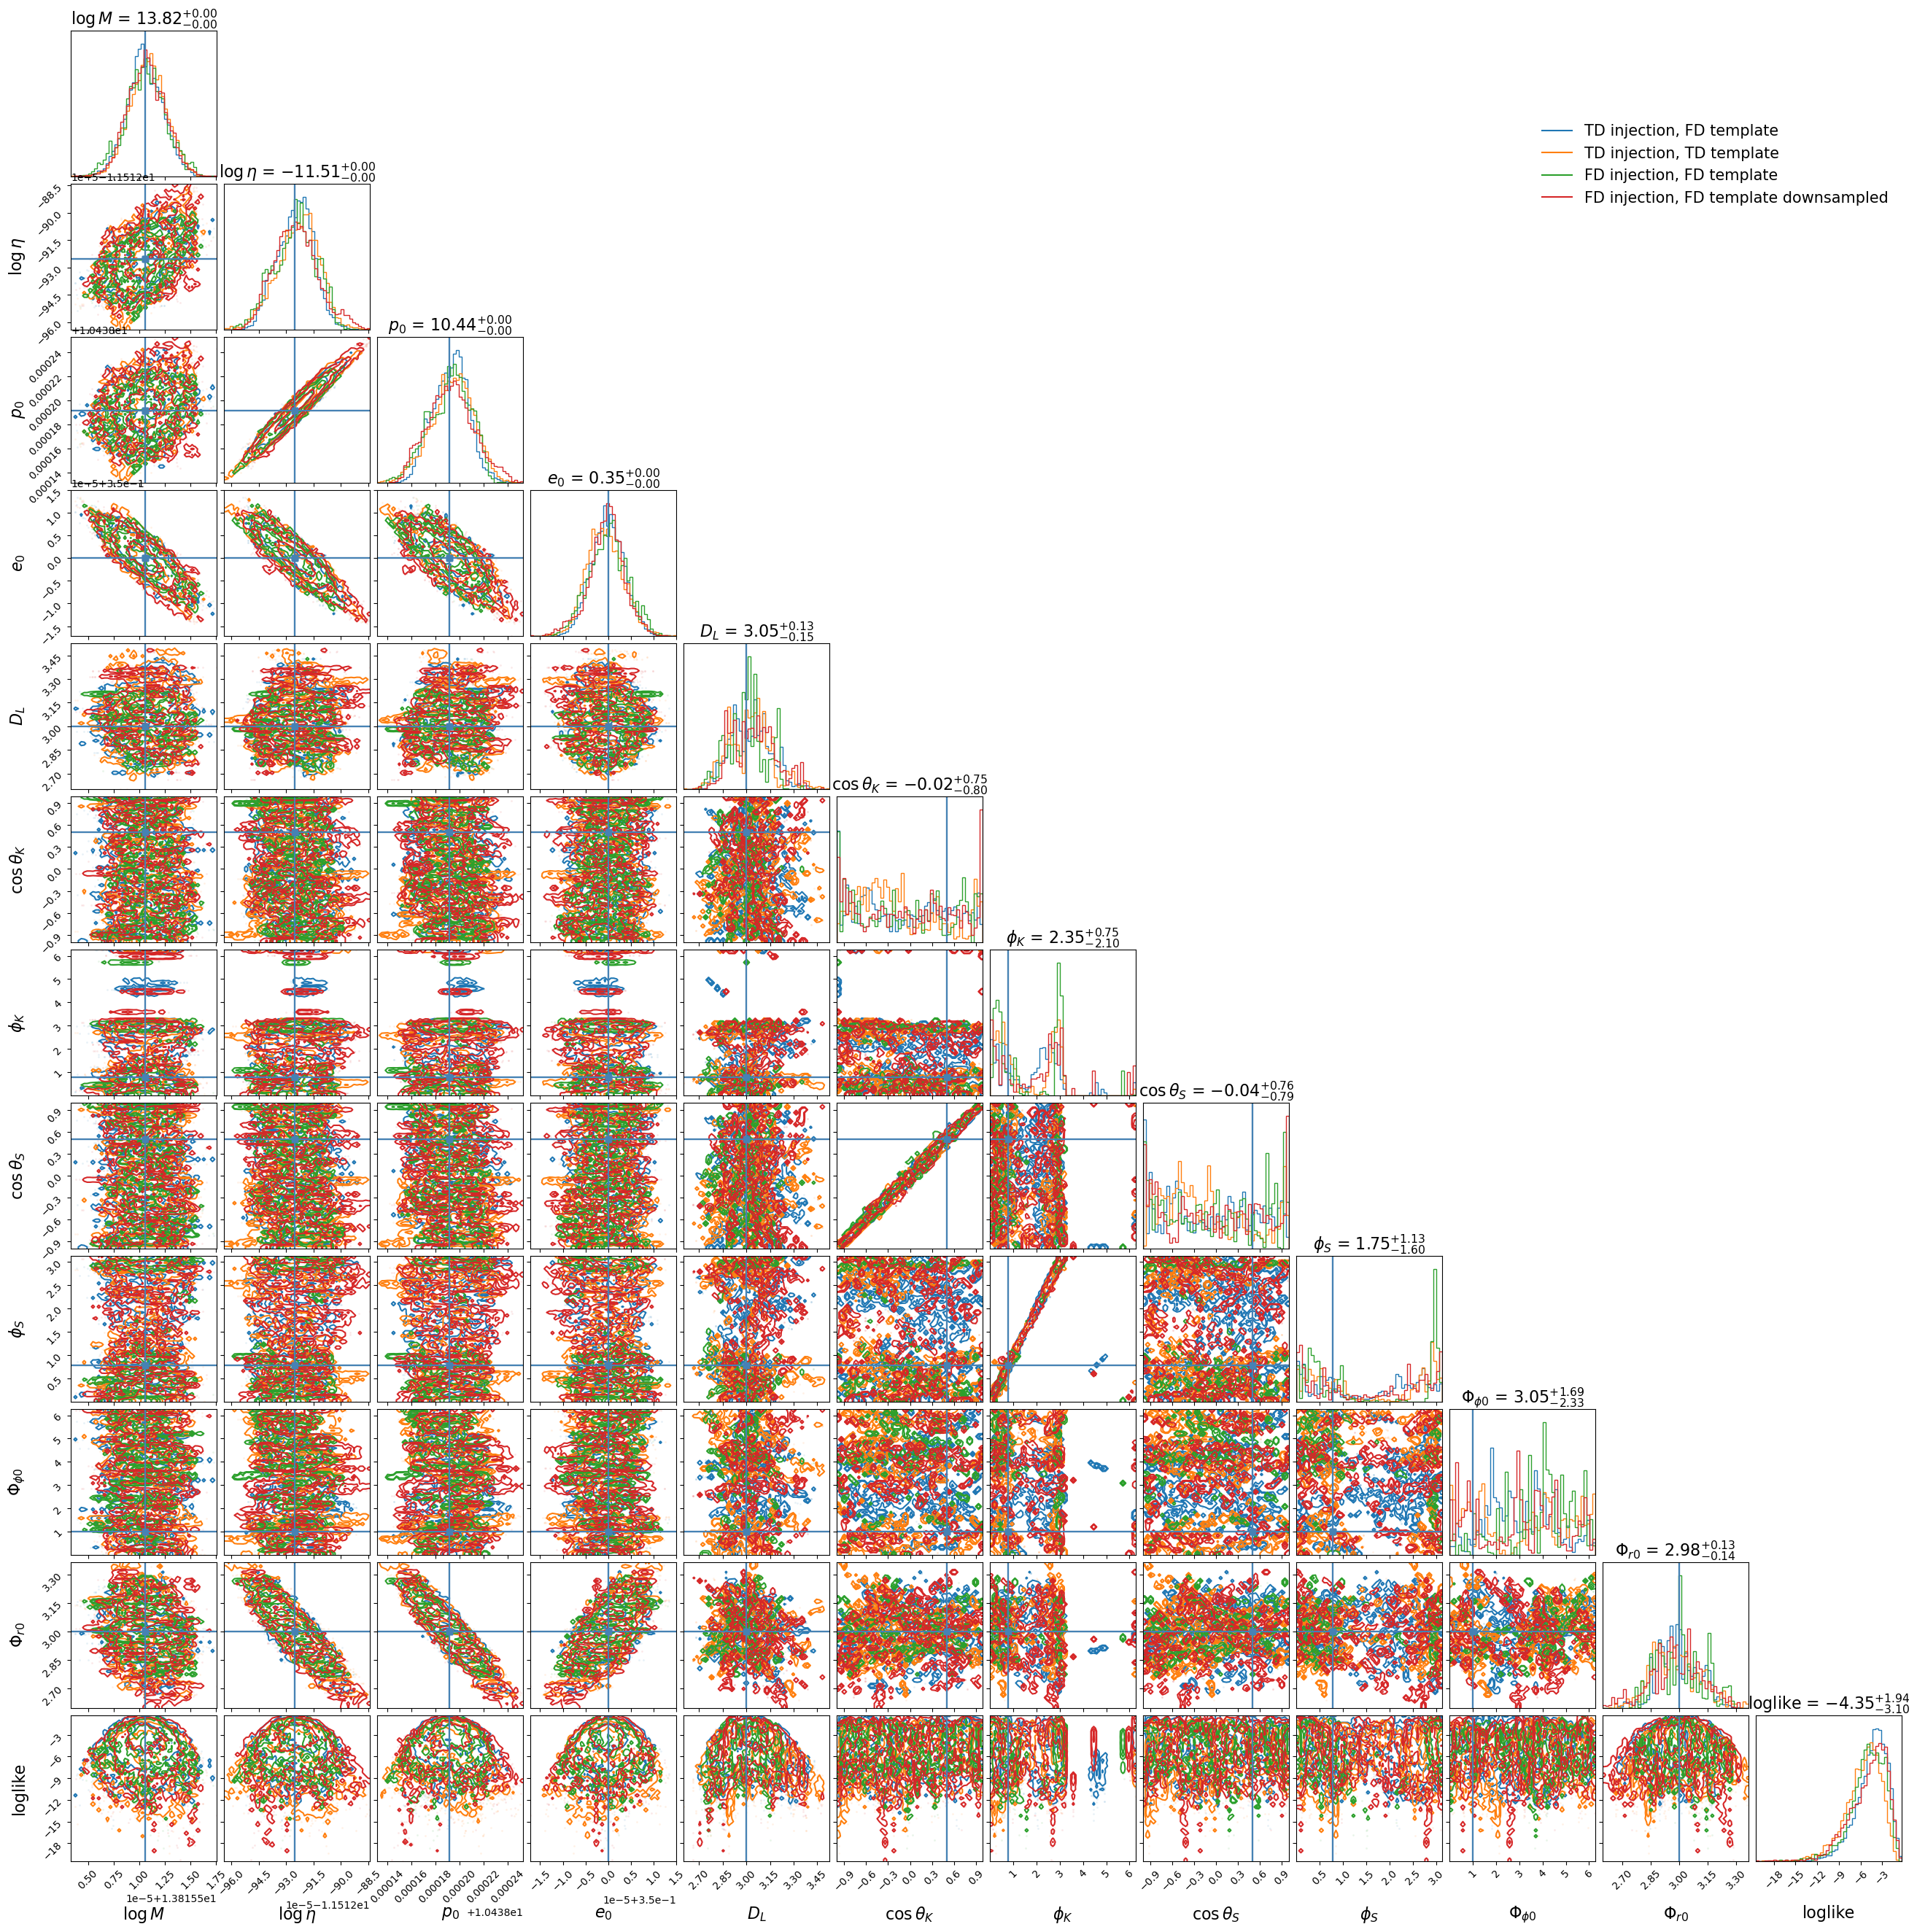

In [138]:
overlaid_corner(samp_final, 
                ['TD injection, FD template', 'TD injection, TD template', 
                 'FD injection, FD template', 'FD injection, FD template downsampled'])#, name_save='posterior_comparison')

In [129]:
# np.save("covariance.npy",np.cov(samp_final[2].T))

In [19]:
# np.save("samples_to_test",samp_final[0][-5000:])